# BBSR Challenge | N3XTCODER AI for Impact

 Welcome to the BBSR Challenge Data Analysis Notebook! 👋
 
 This notebook is designed to give you a quick overview of the ``ÖKOBAUDAT`` and ``tBaustoff`` datasets that you'll be working with during the challenge.
 We'll explore the structure, content, and key characteristics of the data to help you get started.
 
 Let's dive in and take a look at what we're working with! 📊


## Setup

First, let's import the necessary libraries and load the data.

In [2]:
# We will use the pandas library to explore the data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import requests
import json
import re

# Display all availablecolumns in the dataframes
pd.set_option("display.max_columns", None)

## Challenge Goals and Data Analysis Approach

Let's recall the challenge goals. Keep them in mind as we explore the data; they can guide your analysis and implementation.

### **Goal 1**: Material Connection & Disturbance Classification

Using the `ÖKOBAUDAT` and `tBaustoff` datasets, analyze material combinations in building components. Help users understand how different connection types affect disassembly and reuse. Make it easier to identify which connections support circular construction practices and suggest intuitive default connections between materials. Classify connection types according to their pollution potential.

### **Goal 2**: Semantic Material Linking

Enable matching of equivalent materials beyond current sets supported by the mapping between `ÖKOBAUDAT` and `tBaustoff`. Build semantic relationships between similar materials based on their properties and specifications.

### **Goal 3**: Circularity Index Enhancement

Make circularity metrics more user-friendly and contextual. Provide meaningful context around circularity scores using `ÖKOBAUDAT` and `tBaustoff` lifecycle data.



## The Datasets

### ÖKOBAUDAT Dataset

The [`ÖKOBAUDAT`](https://www.oekobaudat.de/en.html) is Germany's standardized database for ecological evaluations of buildings by the [Federal Ministry for Housing, Urban Development and Building (BMWSB)](https://www.bmwsb.bund.de/Webs/BMWSB/DE/startseite/startseite-node.html). At its core lies the life cycle assessment (LCA) data on building materials, construction, transport, energy and disposal processes. 

We provide CSV files for three different versions of the `ÖKOBAUDAT`: years 2020, 2023, and 2024. These files can be found in the `data/OBD/` directory.

| Year | Filename | UUID of the datastock |
|------|----------|------|
| 2020 | OBD_2020_II.csv | 448d1096-2017-4901-a560-f652a83c737e |
| 2023 | OBD_2023_I.csv | 22885a6e-1765-4ade-a35e-ae668bd07256 |
| 2024 | OBD_2024_I.csv | ca70a7e6-0ea4-4e90-a947-d44585783626 |

Note that data entries in `ÖKOBAUDAT` are referred to as *Processes*, not materials, as life cycle assessment is conducted at the process level. If you see a reference to a *Process* in connection with `ÖKOBAUDAT`, it means that the data is related to a speficic material combined with assessments through its entire life cycle.

Let's first explore the `OBD_2024_I` CSV file to understand the structure and content of the `ÖKOBAUDAT` dataset. The other two datasets follow the same structure.

We'll load the data and examine its basic characteristics.

In [3]:
# Read the CSV file into a pandas dataframe; the file is encoded in ISO-8859-1 and uses ; as the delimiter
obd_2024 = pd.read_csv('data/OBD/OBD_2024_I.csv', sep=';', encoding='ISO-8859-1', low_memory=False)

# Convert numeric columns to float automatically
for col in obd_2024.select_dtypes(include=['object']).columns:
    try:
        obd_2024[col] = pd.to_numeric(obd_2024[col].str.replace(',', '.'))
    except:
        pass

# Convert to int64 but ignore NaN values
obd_2024["Referenzjahr"] = pd.to_numeric(obd_2024["Referenzjahr"], errors='coerce').fillna(obd_2024["Referenzjahr"]).astype('Int64')
obd_2024["Gueltig bis"] = pd.to_numeric(obd_2024["Gueltig bis"], errors='coerce').fillna(obd_2024["Gueltig bis"]).astype('Int64')

# Get basic information about the dataframe
obd_2024.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14985 entries, 0 to 14984
Data columns (total 81 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   UUID                                           14985 non-null  object 
 1   Version                                        14985 non-null  object 
 2   Name (de)                                      12848 non-null  object 
 3   Name (en)                                      14945 non-null  object 
 4   Kategorie (original)                           14985 non-null  object 
 5   Kategorie (en)                                 14985 non-null  object 
 6   Konformität                                    14985 non-null  object 
 7   Laenderkennung                                 14982 non-null  object 
 8   Typ                                            14985 non-null  object 
 9   Referenzjahr                                   149

The dataframe has many columns. Moreover, some of the columns are completely empty, and some are only partially filled. We can drop the empty columns and concentrate on annotating the rest. This way, we know what data we are working with.

In [4]:
obd_2024 = obd_2024.drop(columns=obd_2024.columns[obd_2024.isna().all()])
obd_2024.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14985 entries, 0 to 14984
Data columns (total 79 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   UUID                                           14985 non-null  object 
 1   Version                                        14985 non-null  object 
 2   Name (de)                                      12848 non-null  object 
 3   Name (en)                                      14945 non-null  object 
 4   Kategorie (original)                           14985 non-null  object 
 5   Kategorie (en)                                 14985 non-null  object 
 6   Konformität                                    14985 non-null  object 
 7   Laenderkennung                                 14982 non-null  object 
 8   Typ                                            14985 non-null  object 
 9   Referenzjahr                                   149

Now, let's check some key statistics about the dataset. The `UUID` is the unique identifier for each material. Let's look at the number of unique materials  (`UUID`'s) in the dataframe and investigate how these materials are distributed through different categories.

Number of unique materials (UUIDs): 1907
Number of unique categories: 340


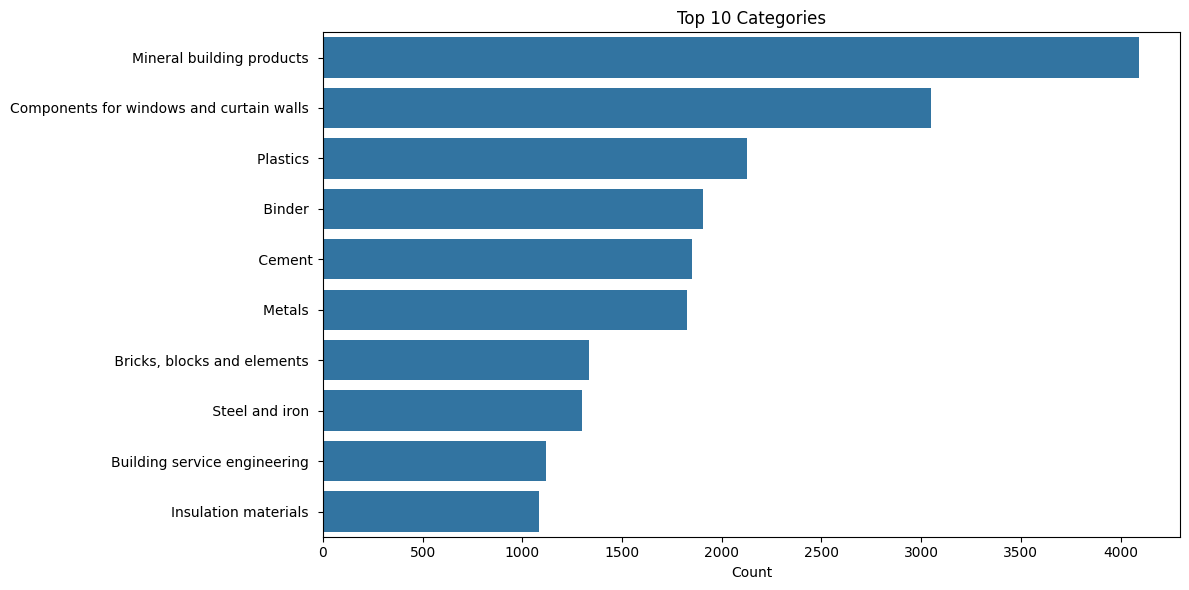

In [5]:
# Count unique materials (UUIDs)
print(f"Number of unique materials (UUIDs): {obd_2024['UUID'].nunique()}")

# Split categories by '/' and flatten the list
all_categories = [category for sublist in obd_2024['Kategorie (en)'].dropna().str.split('/') for category in sublist]

# Strip every occurrence of ' in the categories
all_categories = [category.replace("'", "") for category in all_categories]

# Count occurrences of each category
category_counts = Counter(all_categories)

# Print the number of unique categories after flattening
print(f"Number of unique categories: {len(category_counts)}")

# Plot top 10 categories after flattening
plt.figure(figsize=(12, 6))
top_flattened_categories = category_counts.most_common(10)
sns.barplot(x=[count for category, count in top_flattened_categories], y=[category for category, count in top_flattened_categories])
plt.title('Top 10 Categories')
plt.xlabel('Count')
plt.tight_layout()
plt.show()

Number of unique materials (UUIDs): 1907


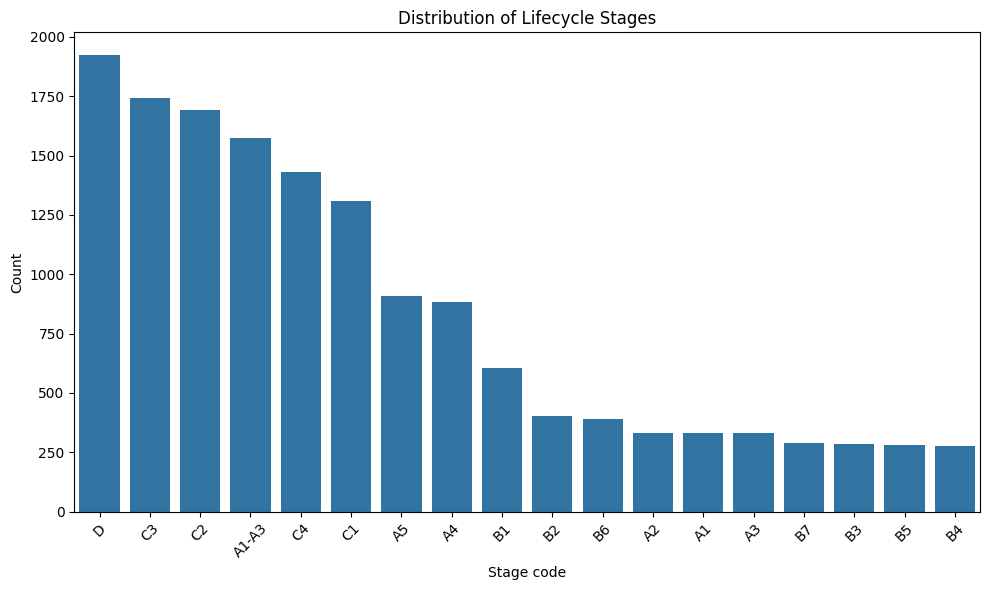

In [6]:
# Count unique materials (UUIDs)
print(f"Number of unique materials (UUIDs): {obd_2024['UUID'].nunique()}")

# Plot distribution of lifecycle stages
modules_count = obd_2024['Modul'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=modules_count.index, y=modules_count.values)
plt.title('Distribution of Lifecycle Stages')
plt.xlabel('Stage code')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Number of unique materials (UUIDs): 1907
Number of unique types of data: 5


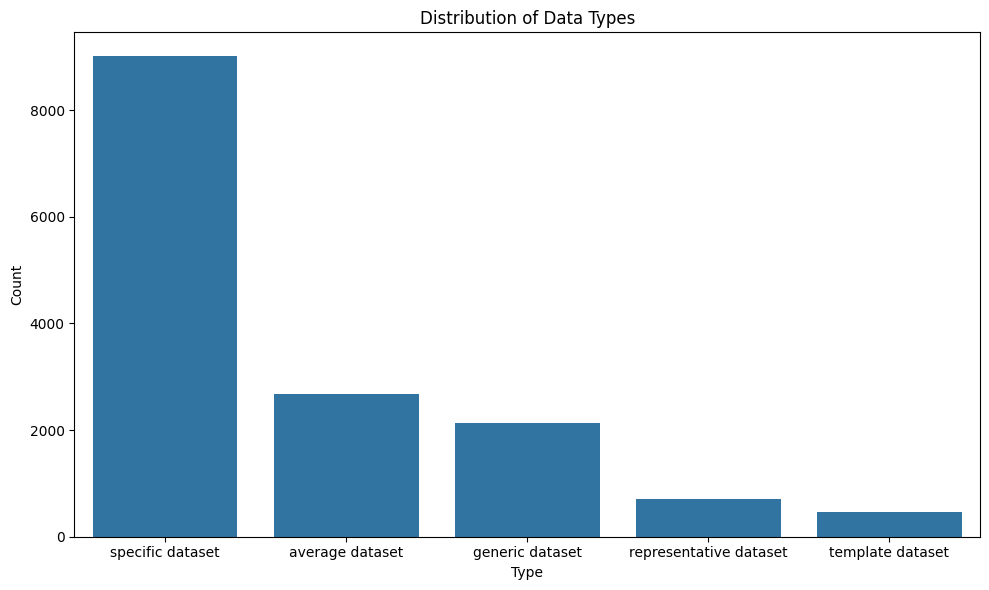

In [7]:
# Count unique materials (UUIDs)
print(f"Number of unique materials (UUIDs): {obd_2024['UUID'].nunique()}")

# Count unique type of data entry:
print(f"Number of unique types of data: {obd_2024['Typ'].nunique()}")

# Plot distribution of data types
data_types_count = obd_2024['Typ'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=data_types_count.index, y=data_types_count.values)
plt.title('Distribution of Data Types')
plt.xlabel('Type')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

Additionally, we can look at the basic statistics on the dataset entries.

In [8]:
obd_2024.describe()

,Referenzjahr,Gueltig bis,Schuettdichte (kg/m3),Flaechengewicht (kg/m2),Rohdichte (kg/m3),Schichtdicke (m),Ergiebigkeit (m2),Laengengewicht (kg/m),Stueckgewicht (kg),Umrechungsfaktor auf 1kg,biogener Kohlenstoffgehalt in kg,biogener Kohlenstoffgehalt (Verpackung) in kg,GWP,ODP,POCP,AP,EP,ADPE,ADPF,PERE,PERM,PERT,PENRE,PENRM,PENRT,SM,RSF,NRSF,FW,HWD,NHWD,RWD,CRU,MFR,MER,EEE,EET,AP (A2),GWPtotal (A2),GWPbiogenic (A2),GWPfossil (A2),GWPluluc (A2),ETPfw (A2),PM (A2),EPmarine (A2),EPfreshwater (A2),EPterrestrial (A2),HTPc (A2),HTPnc (A2),IRP (A2),SOP (A2),ODP (A2),POCP (A2),ADPF (A2),ADPE (A2),WDP (A2)
count,14982.0,14982.0,264.000000,8181.000000,7372.000000,6725.000000,193.000000,928.000000,188.000000,2297.000000,1781.000000,2613.000000,30.000000,3.000000e+01,30.000000,30.000000,30.000000,3.000000e+01,30.000000,14205.000000,14150.000000,14204.000000,1.420500e+04,14166.000000,1.420400e+04,14176.000000,14178.000000,14178.000000,14203.000000,1.420100e+04,14202.000000,14202.000000,14148.000000,14176.000000,14163.000000,14172.000000,14171.000000,14175.000000,14175.000000,1.417500e+04,14175.000000,13980.000000,10354.000000,1.043800e+04,14174.000000,1.417500e+04,14175.000000,1.035400e+04,1.035400e+04,10446.000000,9622.000000,1.417500e+04,14175.000000,1.417500e+04,1.417500e+04,1.417500e+04
mean,2022.477039,2027.476038,1290.120679,250.604502,1797.465155,0.258395,2.570508,14.038785,1210.313468,11.092912,22.453528,1.230799,15.886533,9.650560e-10,0.001154,0.025522,0.003552,1.739733e-06,214.365000,175.764867,16.166381,191.811079,3.748981e+02,4.509357,3.738669e+02,43.200162,19.296311,12.351600,1.327263,2.472902e-02,8.218466,0.009394,0.546069,53.041856,1.497937,7.028402,12.246170,0.124453,31.726961,-9.301172e-01,32.609357,0.037701,224.171960,1.285741e-01,0.024467,6.878315e-03,0.273190,6.897403e-03,3.095577e-02,9.849131,252.737035,1.516069e-04,0.083207,3.703608e+02,3.096172e+00,6.729913e+02
std,1.122127,1.066286,1086.834965,740.321611,2054.296597,1.079328,1.028431,28.182344,5890.104638,65.490271,71.101101,2.990426,56.794048,3.407206e-09,0.011675,0.076034,0.008686,6.004212e-06,825.662028,4551.233828,901.421519,4635.454902,1.349271e+04,1196.108208,1.355812e+04,390.451411,319.265677,121.356409,115.599635,2.015766e+00,276.478388,0.275843,25.004277,645.290801,29.103030,158.664083,223.036336,10.631360,1277.038227,8.888160e+01,1272.511089,2.653356,3174.472558,7.283167e+00,0.935617,1.682683e+00,9.922257,5.310214e-01,2.183802e+00,587.487150,5277.855430,6.922965e-03,3.131678,1.357923e+04,1.093203e+02,6.091266e+04
min,2014.0,2019.0,1.580000,0.058000,0.249000,0.000000,0.840000,0.001140,0.692000,0.000411,0.000000,-0.070000,-7.350000,-1.690000e-09,-0.019200,-0.020500,-0.002340,-6.190000e-07,-86.600000,-104543.704872,-17640.000000,-104543.704872,-5.031442e+05,-43142.400000,-5.031442e+05,-4694.731692,-0.064600,-0.035100,-371.700871,-4.947233e+01,-15083.455234,-5.905945,-0.099600,-21.424077,-0.099600,-137.000000,-237.000000,-639.388379,-56389.189044,-1.758913e+03,-56534.759938,-162.857314,-37700.000000,-4.450000e+01,-47.049489,-1.311663e+02,-495.379623,-7.940000e+00,-1.320000e+01,-431.820000,-17877.320286,-2.278768e-01,-161.787036,-5.031152e+05,-9.130000e+02,-2.099973e+04
25%,2022.0,2027.0,290.000000,3.600000,272.000000,0.008310,1.820400,0.610000,1.214000,0.000430,0.000000,0.010000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.260000e-07,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
50%,2023.0,2028.0,900.000000,29.100000,1420.000000,0.080000,2.680000,2.630000,2.364000,0.000436,0.000000,0.110000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.047424,0.000000,0.037855,7.250000e-01,0.000000,5.15435

You can find a comprehensive description of the `ÖKOBAUDAT` fields in the [**README**](README.md). 

The database follows the European Standard EN 15804+A2 for sustainable building assessment, which is additionally reflected in the column names of the Environmental Impact Indicators (`(A2)` postfix in the column name). Impact values can be positive (environmental burden) or negative (environmental credit).

### tBaustoff Dataset

The `tBaustoff` dataset has been developed by the [Austrian Institute for Healthy and Ecological Building (IBO)](https://www.ibo.at/) to complement circularity assessments of the `ÖKOBAUDAT` dataset. A snapshot of some `tBaustoff` data in the 2024-Q4 release is available as a CSV file and can be found in the `data/tBaustoff/` directory.

Let's load the `tBaustoff` data:

In [9]:
tbs = pd.read_csv('data/tBaustoff/tBaustoff_with_OBD_mapping.csv', low_memory=False)
tbs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 815 entries, 0 to 814
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   oekobaudatProcessUuid        728 non-null    object 
 1   oekobaudatDatastockUuid      731 non-null    object 
 2   oekobaudatDatastockName      731 non-null    object 
 3   productId                    815 non-null    int64  
 4   tBaustoffVersion             815 non-null    object 
 5   productName                  815 non-null    object 
 6   eolCategoryId                815 non-null    int64  
 7   eolCategoryName              815 non-null    object 
 8   eolScenarioUnbuiltReal       815 non-null    object 
 9   eolScenarioUnbuiltPotential  815 non-null    object 
 10  technologyFactor             815 non-null    float64
dtypes: float64(1), int64(2), object(8)
memory usage: 70.2+ KB


Let's examine the first few rows to understand the structure:

In [10]:
# Display the first few rows
tbs.head()

,oekobaudatProcessUuid,oekobaudatDatastockUuid,oekobaudatDatastockName,productId,tBaustoffVersion,productName,eolCategoryId,eolCategoryName,eolScenarioUnbuiltReal,eolScenarioUnbuiltPotential,technologyFactor
0,3b1f0c75-07a4-4182-b310-5529fc5b54a6,22885a6e-1765-4ade-a35e-ae668bd07256,OBD_2023_I,1,2024-Q4,Acetyliertes Holz,1,Holz - acetyliert,EV+,EV+,0.00
1,0dec19c7-53db-4cb9-bbba-4d44d3da62a9,ca70a7e6-0ea4-4e90-a947-d44585783626,OBD_2024_I,1,2024-Q4,Acetyliertes Holz,1,Holz - acetyliert,EV+,EV+,0.00
2,bd6d6d89-b76d-4002-a217-afffbb8aa308,448d1096-2017-4901-a560-f652a83c737e,OBD_2020_II,2,2024-Q4,Aluminium Profil,2,Alu unbeschichtet od. eloxiert (Sz. Knetleg zu...,RC+,CL+,0.75
3,fdc99ab8-d843-44ec-a66c-92367d244321,22885a6e-1765-4ade-a35e-ae668bd07256,OBD_2023_I,2,2024-Q4,Aluminium Profil,2,Alu unbeschichtet od. eloxiert (Sz. Knetleg zu...,RC+,CL+,0.75
4,3feca796-791b-46d3-8160-95ef243ffb9d,ca70a7e6-0ea4-4e90-a947-d44585783626,OBD_2024_I,2,2024-Q4,Aluminium Profil,2,Alu unbeschichtet od. eloxiert (Sz. Knetleg zu...,RC+,CL+,0.75


The key columns in this dataset include:
- `oekobaudatProcessUuid`: Links to the ÖKOBAUDAT dataset
- `productId` and `productName`: Identify the material in tBaustoff
- `eolCategoryId` and `eolCategoryName`: End-of-life category
- `eolScenarioUnbuiltReal` and `eolScenarioUnbuiltPotential`: End-of-life scenarios
- `technologyFactor`: Technology factor for reuse/recycling

As with `ÖKOBAUDAT`, you can find a description of the `tBaustoff` columns in the [**README**](README.md). Descriptions of methodology and scenario assignment are available in the [**supplements**](supplements/) folder to support you.

Let's count some key statistics:

Number of unique tBaustoff products: 345


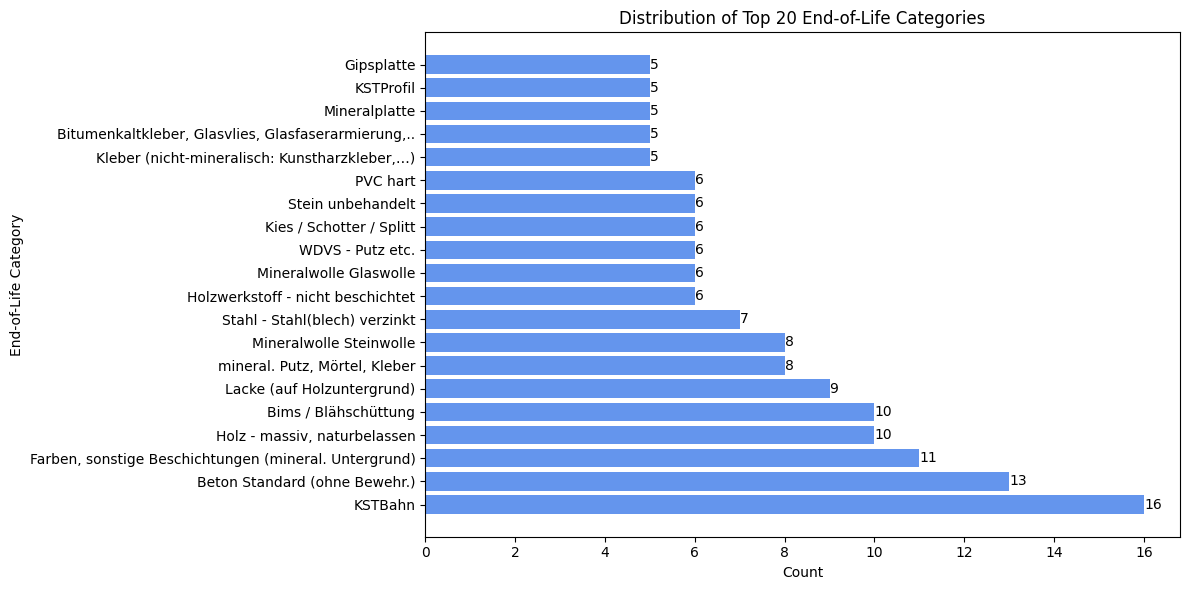

In [11]:
# Count unique materials
print(f"Number of unique tBaustoff products: {tbs['productId'].nunique()}")

# Count and visualize top 20 EOL categories (counting unique product IDs per category)
plt.figure(figsize=(12, 6))
eol_counts = tbs.drop_duplicates('productId')['eolCategoryName'].value_counts().head(20)

# Create horizontal bar chart for better readability of category names
bars = plt.barh(eol_counts.index, eol_counts.values, color='cornflowerblue')

# Add count labels to the bars
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, 
             f'{width}', ha='left', va='center')

plt.xlabel('Count')
plt.ylabel('End-of-Life Category')
plt.title('Distribution of Top 20 End-of-Life Categories')
plt.tight_layout()
plt.show()

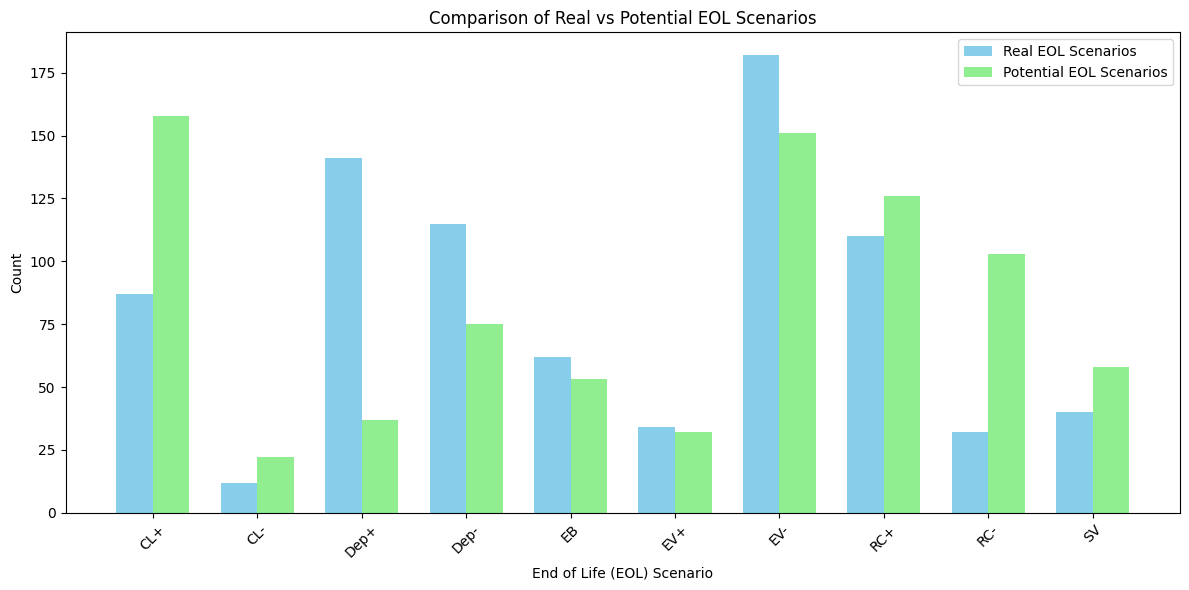

In [12]:
# Create a single plot comparing real and potential EOL scenarios
plt.figure(figsize=(12, 6))

# Get counts for both real and potential scenarios
real_counts = tbs['eolScenarioUnbuiltReal'].value_counts()
potential_counts = tbs['eolScenarioUnbuiltPotential'].value_counts()

# Get all unique scenario types
all_scenarios = sorted(set(real_counts.index) | set(potential_counts.index))

# Set up bar positions
x = np.arange(len(all_scenarios))
width = 0.35

# Create bars
plt.bar(x - width/2, [real_counts.get(scenario, 0) for scenario in all_scenarios], 
        width, label='Real EOL Scenarios', color='skyblue')
plt.bar(x + width/2, [potential_counts.get(scenario, 0) for scenario in all_scenarios], 
        width, label='Potential EOL Scenarios', color='lightgreen')

# Add labels and title
plt.xlabel('End of Life (EOL) Scenario')
plt.ylabel('Count')
plt.title('Comparison of Real vs Potential EOL Scenarios')
plt.xticks(x, all_scenarios, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

#### Analyzing Contamination in Demolition Materials

The tBaustoff dataset also includes information about contamination classifications for materials after the demolition process. Let's explore this data to understand the types and distribution of contaminants.

In [3]:
# Load the data
pollutants = pd.read_csv('data/tBaustoff/pollutant_combinations.csv')
pollutants.head()

,Baumaterial ohne Fremd-/Störstoffe,Fremd-/Störstoffbeschreibung,Störstoffklasse
0,Gussasphaltestrich,ohne Fremd-/Störstoffe,S0
1,Gussasphaltestrich,"Klebstoff-, Bodenbelagsreste, Trennfolien",S2
2,Gussasphaltestrich,Heizungsverteilrohre,S3
3,Beton,ohne Fremd-/Störstoffe,S0
4,Beton,Stahlbewehrung,S2


First, let's examine the contamination categories and their frequency in the dataset. This will help us understand what types of foreign substances or contaminants are commonly found in demolition materials and how they are classified.

In [13]:
 # For each pollutant class, what are the common materials and contaminants?
for pollutant_class in sorted(pollutants['Störstoffklasse'].unique()):
    class_data = pollutants[pollutants['Störstoffklasse'] == pollutant_class]
    print(f"\n\nPollutant Class {pollutant_class} - {len(class_data)} combinations")
    if pollutant_class != 'S0':  # S0 is always "ohne Fremd-/Störstoffe"
        common_terms = []
        for desc in class_data['Fremd-/Störstoffbeschreibung']:
            if pd.notna(desc) and desc != "ohne Fremd-/Störstoffe":
                words = re.findall(r'[\w/]+', desc.lower())
                common_terms.extend(words)
        print(f"Common contaminants: {Counter(common_terms).most_common(5)}")



Pollutant Class S0 - 52 combinations


Pollutant Class S1 - 14 combinations
Common contaminants: [('metallteile', 4), ('lehmfarbe', 3), ('lehmputz', 2), ('gipsspachtel', 2), ('naturfarbe', 2)]


Pollutant Class S2 - 38 combinations
Common contaminants: [('klebstoffreste', 12), ('bitumenreste', 9), ('belagsreste', 8), ('feinkörn', 7), ('material', 7)]


Pollutant Class S3 - 31 combinations
Common contaminants: [('klebespachtel', 11), ('bitumen', 10), ('gips', 9), ('in', 8), ('mengen', 8)]


Pollutant Class S4 - 12 combinations
Common contaminants: [('problematische', 9), ('beschichtung', 9), ('schwermetalle', 9), ('halogene', 9), ('biozide', 9)]



Pollutant class distribution:


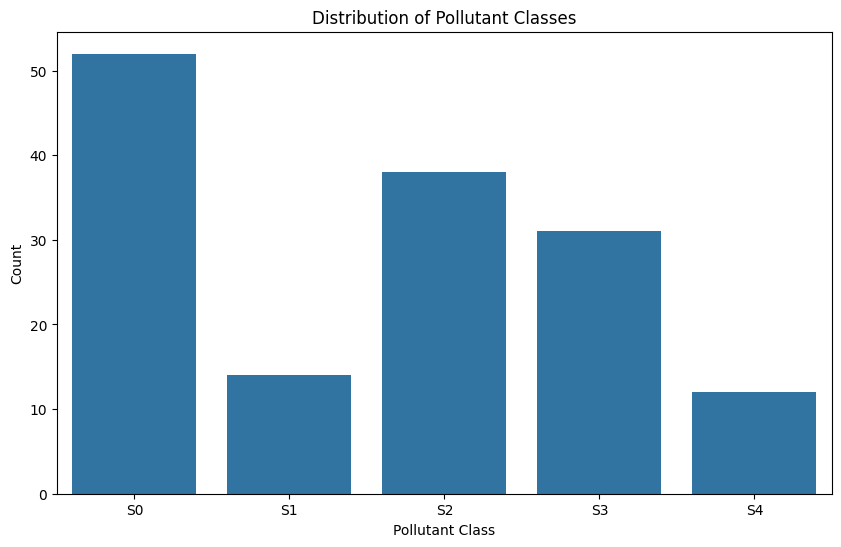

In [10]:
# Basic statistics 
print("\nPollutant class distribution:")
# Visualize pollutant class distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=pollutants, x='Störstoffklasse', order=sorted(pollutants['Störstoffklasse'].unique()))
plt.title('Distribution of Pollutant Classes')
plt.xlabel('Pollutant Class')
plt.ylabel('Count')
plt.show()



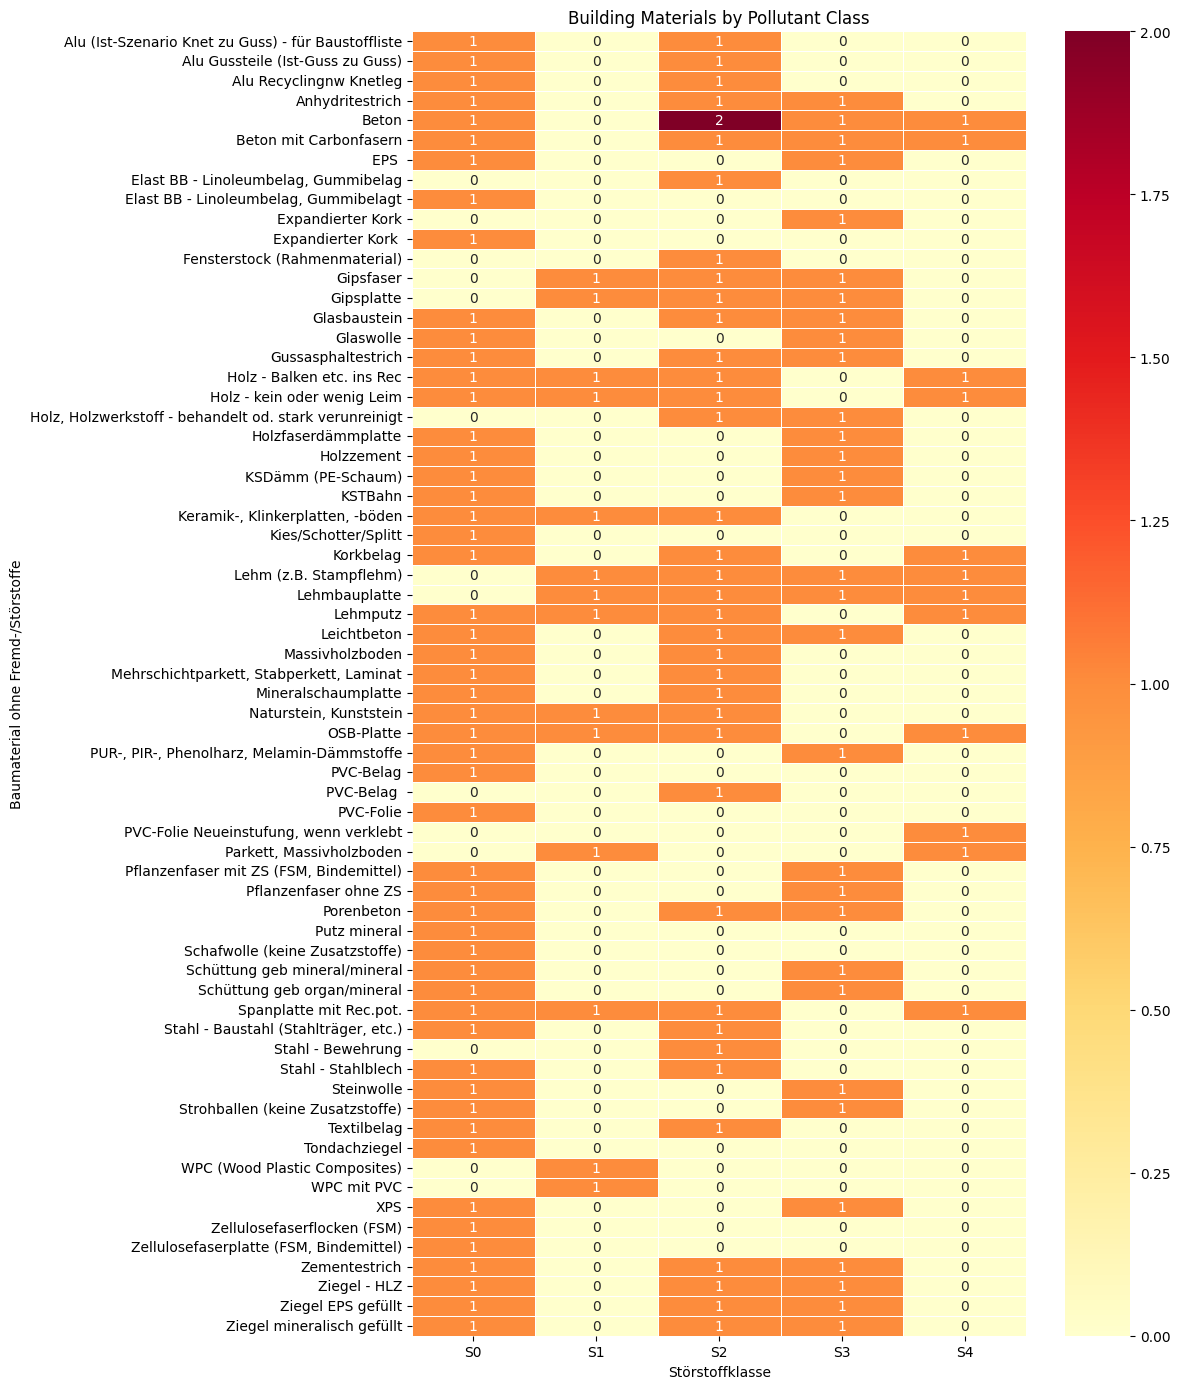

In [11]:
# Create a heatmap to visualize material vs pollutant class
# Create a pivot table
pivot_data = pd.crosstab(pollutants['Baumaterial ohne Fremd-/Störstoffe'], pollutants['Störstoffklasse'])
# Plot heatmap
plt.figure(figsize=(12, 14))
sns.heatmap(pivot_data, cmap='YlOrRd', linewidths=0.5, annot=True, fmt='d')
plt.title('Building Materials by Pollutant Class')
plt.tight_layout()
plt.show()

In [12]:
# Analyze which materials have the most severe pollutant classifications
severe_pollutants = pollutants[pollutants['Störstoffklasse'] == 'S4']

# Extract and print unique contamination descriptions
print("\nUnique contamination descriptions in severe pollutants (S4):")
unique_descriptions = severe_pollutants['Fremd-/Störstoffbeschreibung'].unique()
for desc in unique_descriptions:
    print(f"- {desc}")


Unique contamination descriptions in severe pollutants (S4):
- Reaktionsharzbeschichtung (z.B. Kunstharzbelag)
- problematische Beschichtung (Schwermetalle, Halogene, Biozide)
- Konvent. Wandfarbe, problematische Beschichtung  (Schwermetalle, Halogene, Biozide)
- Klebereste


## Dataset Mappings

For some goals, we need to understand how materials in `ÖKOBAUDAT` are mapped to `tBaustoff`. Let's examine the current mapping.

In [13]:
# Check how many ÖKOBAUDAT materials are mapped to tBaustoff
obd_uuids = set(obd_2024['UUID'].unique())
mapped_uuids = set(tbs['oekobaudatProcessUuid'].dropna().unique())

print(f"Total ÖKOBAUDAT materials: {len(obd_uuids)}")
print(f"Mapped to tBaustoff: {len(mapped_uuids)}")
print(f"Percentage mapped: {len(mapped_uuids) / len(obd_uuids) * 100:.2f}%")

# Check how many tBaustoff products are mapped to multiple ÖKOBAUDAT materials
tbs_product_counts = tbs.groupby('productId')['oekobaudatProcessUuid'].nunique()
multiple_mappings = tbs_product_counts[tbs_product_counts > 1]

print(f"\nNumber of tBaustoff products with multiple ÖKOBAUDAT mappings: {len(multiple_mappings)}")
if len(multiple_mappings) > 0:
    print("Examples:")
    for product_id in multiple_mappings.index[:5]:  # Show first 5 examples
        product_name = tbs[tbs['productId'] == product_id]['productName'].iloc[0]
        print(f"  Product ID {product_id} ({product_name}): {tbs_product_counts[product_id]} mappings")


Total ÖKOBAUDAT materials: 1907
Mapped to tBaustoff: 728
Percentage mapped: 38.18%

Number of tBaustoff products with multiple ÖKOBAUDAT mappings: 260
Examples:
  Product ID 1 (Acetyliertes Holz ): 2 mappings
  Product ID 2 (Aluminium Profil): 3 mappings
  Product ID 3 (Aluminiumblech): 3 mappings
  Product ID 4 (Armierung (für Kunstharzspachtel)): 3 mappings
  Product ID 6 (Asphalttragschicht - Infrastruktur): 3 mappings


## Examining an Example Material

To better understand the data, let's pick an example material (e.g., concrete) and examine its lifecycle data from both datasets:

For example, we are interested in the lifecycle of copper sheets. 

<img src="img/copper_sheet.png" width="100">

The UUID of the copper sheet is: `e5a4ebf9-0e5c-4fd8-bb04-1acb5497312f`. Let's filter the dataframe for this UUID and look at the first few rows.

You can cross-reference [the material data](https://oekobaudat.de/OEKOBAU.DAT/datasetdetail/process.xhtml?lang=en&uuid=e5a4ebf9-0e5c-4fd8-bb04-1acb5497312f&version=20.24.070)  on ÖKOBAUDAT website.


In [14]:
copper_uuid = 'e5a4ebf9-0e5c-4fd8-bb04-1acb5497312f'

# Filter the dataframe for the UUID
copper = obd_2024[obd_2024['UUID'] == copper_uuid]

print(f"Example material: {copper['Name (en)'].iloc[0]}")
print(f"UUID: {copper_uuid}")
copper.head()

Example material: Copper sheet
UUID: e5a4ebf9-0e5c-4fd8-bb04-1acb5497312f


,UUID,Version,Name (de),Name (en),Kategorie (original),Kategorie (en),Konformität,Laenderkennung,Typ,Referenzjahr,Gueltig bis,URL,Declaration owner,Veroeffentlicht am,Registrierungsnummer,Registrierungsstelle,UUID des Vorgängers,Version des Vorgängers,Bezugsgroesse,Bezugseinheit,Referenzfluss-UUID,Referenzfluss-Name,Schuettdichte (kg/m3),Flaechengewicht (kg/m2),Rohdichte (kg/m3),Schichtdicke (m),Ergiebigkeit (m2),Laengengewicht (kg/m),Stueckgewicht (kg),Umrechungsfaktor auf 1kg,biogener Kohlenstoffgehalt in kg,biogener Kohlenstoffgehalt (Verpackung) in kg,Modul,Szenario,Szenariobeschreibung,GWP,ODP,POCP,AP,EP,ADPE,ADPF,PERE,PERM,PERT,PENRE,PENRM,PENRT,SM,RSF,NRSF,FW,HWD,NHWD,RWD,CRU,MFR,MER,EEE,EET,AP (A2),GWPtotal (A2),GWPbiogenic (A2),GWPfossil (A2),GWPluluc (A2),ETPfw (A2),PM (A2),EPmarine (A2),EPfreshwater (A2),EPterrestrial (A2),HTPc (A2),HTPnc (A2),IRP (A2),SOP (A2),ODP (A2),POCP (A2),ADPF (A2),ADPE (A2),WDP (A2)
12695,e5a4ebf9-0e5c-4fd8-bb04-1acb5497312f,20.24.070,Kupferbleche,Copper sheet,'Metalle' / 'Kupfer' / 'Kupferbleche','Metals' / 'Copper' / 'Copper sheets','EN 15804+A2 (EF 3.1)',DE,generic dataset,2023,2026,https://www.oekobaudat.de/OEKOBAU.DAT/resource...,Sphera Solutions GmbH,NaN,NaN,Sphera Solutions GmbH,e5a4ebf9-0e5c-4fd8-bb04-1acb5497312f,NaN,1,kg,a412f4e4-e485-437b-94b5-8bc5fbd68457,Copper sheet,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A1-A3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.727548,0.0,16.727548,53.612324,0.0,53.612324,0.0,0.0,0.0,0.051509,1.715486e-08,1.908881,1.808093e-04,0.0,0.0,0.0,0.0,0.0,0.079434,5.059849,-0.027591,5.065703,0.021737,NaN,NaN,0.004553,9.775260e-06,0.047362,NaN,NaN,NaN,NaN,2.367660e-11,0.016035,53.608414,3.568298e-03,2.946332
12696,e5a4ebf9-0e5c-4fd8-bb04-1acb5497312f,20.24.070,Kupferbleche,Copper sheet,'Metalle' / 'Kupfer' / 'Kupferbleche','Metals' / 'Copper' / 'Copper sheets','EN 15804+A2 (EF 3.1)',DE,generic dataset,2023,2026,https://www.oekobaudat.de/OEKOBAU.DAT/resource...,Sphera Solutions GmbH,NaN,NaN,Sphera Solutions GmbH,e5a4ebf9-0e5c-4fd8-bb04-1acb5497312f,NaN,1,kg,a412f4e4-e485-437b-94b5-8bc5fbd68457,Copper sheet,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006042,0.0,0.006042,0.054594,0.0,0.054594,0.0,0.0,0.0,0.000006,2.657800e-12,0.000009,8.689616e-08,0.0,0.0,0.0,0.0,0.0,0.000005,0.004260,0.000022,0.004158,0.000080,NaN,NaN,0.000002,1.132273e-08,0.000024,NaN,NaN,NaN,NaN,1.300000e-15,0.000005,0.054593,7.055990e-10,0.000030
12697,e5a4ebf9-0e5c-4fd8-bb04-1acb5497312f,20.24.070,Kupferbleche,Copper sheet,'Metalle' / 'Kupfer' / 'Kupferbleche','Metals' / 'Copper' / 'Copper sheets','EN 15804+A2 (EF 3.1)',DE,generic dataset,2023,2026,https://www.oekobaudat.de/OEKOBAU.DAT/resource...,Sphera Solutions GmbH,NaN,NaN,Sphera Solutions GmbH,e5a4ebf9-0e5c-4fd8-bb04-1acb5497312f,NaN,1,kg,a412f4e4-e485-437b-94b5-8bc5fbd68457,Copper sheet,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000e+00,0.000000,0.000000e+00,0.0,1.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000e+00,0.000000,NaN,NaN,NaN,NaN,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000
12698,e5a4ebf9-0e5c-4fd8-bb04-1acb5497312f,20.24.070,Kupferbleche,Copper sheet,'Metalle' / 'Kupfer' / 'Kupferbleche','Metals' / 'Copper' / 'Copper sheets','EN 15804+A2 (EF 3.1)',DE,generic dataset,2023,2026,https://www.oekobaudat.de/OEKOBAU.DAT/resource...,Sphera Solutions GmbH,NaN,NaN,Sphera Solutions GmbH,e5a4ebf9-0e5c-4fd8-bb04-1acb5497312f,NaN,1,kg,a412f4e4-e485-437b-94b5-8bc5fbd68457,Copper sheet,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-10.203748,0.0,-10.203748,-29.680927,0.0,-29.680927,0.0,0.0,0.0,-0.034841,-7.715443e-09,-1.330788,3.728217e-04,0.0,0.0,0.0,0.0,0.0,-0.059720,-3.163261,0.028520,-3.175916,-0.015865,NaN,NaN,-0.003234,-6.520223e-06,-0.033521,NaN,NaN,NaN,NaN,-1.384480e-11,-0.011519,-29.678053,-2.719910e-03,-2.092283


In [15]:
# Get all lifecycle entries for this material
material_lifecycle = obd_2024[obd_2024['UUID'] == copper_uuid].sort_values('Modul')

# Display lifecycle modules for this material
print("\nLifecycle modules for this material:")
for _, row in material_lifecycle.iterrows():
    print(f"Module {row['Modul']}")


Lifecycle modules for this material:
Module A1-A3
Module C2
Module C3
Module D


The dataset contains multiple rows for the same material. To understand why there are duplicates, let's pay attention to the ``Modul`` column -- it indicates the lifecycle stage of the material. So, each dataset represents environmental impacts across different life cycle stages:

- **A**: production, transport and installation phase
- **B**: use phase
- **C**: deconstruction and disposal phase    
- **D**: recycling potential and benefits

and the environmental impact of the material varies from one stage to another. The technology description on the website contains more contextual information.

![Copper sheet lifecycle](img/copper_tech_description.png)

Unfortunately, it also looks like a lot of the data is still missing (``NaN``'s in the dataframe). However, the amount of data varies from one material to another. You also won't need all the data for the challenge. We'll select the columns that are most relevant; however, feel free to explore the data further.

In [16]:
## Select the relevant columns
copper.describe()

,Referenzjahr,Gueltig bis,Schuettdichte (kg/m3),Flaechengewicht (kg/m2),Rohdichte (kg/m3),Schichtdicke (m),Ergiebigkeit (m2),Laengengewicht (kg/m),Stueckgewicht (kg),Umrechungsfaktor auf 1kg,biogener Kohlenstoffgehalt in kg,biogener Kohlenstoffgehalt (Verpackung) in kg,GWP,ODP,POCP,AP,EP,ADPE,ADPF,PERE,PERM,PERT,PENRE,PENRM,PENRT,SM,RSF,NRSF,FW,HWD,NHWD,RWD,CRU,MFR,MER,EEE,EET,AP (A2),GWPtotal (A2),GWPbiogenic (A2),GWPfossil (A2),GWPluluc (A2),ETPfw (A2),PM (A2),EPmarine (A2),EPfreshwater (A2),EPterrestrial (A2),HTPc (A2),HTPnc (A2),IRP (A2),SOP (A2),ODP (A2),POCP (A2),ADPF (A2),ADPE (A2),WDP (A2)
count,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.000000,4.0,4.000000,4.000000,4.0,4.000000,4.0,4.0,4.0,4.000000,4.000000e+00,4.000000,4.000000e+00,4.0,4.00,4.0,4.0,4.0,4.000000,4.000000,4.000000,4.000000,4.000000,0.0,0.0,4.000000e+00,4.000000e+00,4.000000,0.0,0.0,0.0,0.0,4.000000e+00,4.000000,4.000000,4.000000e+00,4.000000
mean,2023.0,2026.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.632461,0.0,1.632461,5.996498,0.0,5.996498,0.0,0.0,0.0,0.004168,2.360519e-09,0.144526,1.384295e-04,0.0,0.25,0.0,0.0,0.0,0.004930,0.475212,0.000238,0.473486,0.001488,NaN,NaN,3.302944e-04,8.165899e-07,0.003466,NaN,NaN,NaN,NaN,2.458275e-12,0.001130,5.996239,2.120971e-04,0.213520
std,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.154486,0.0,11.154486,34.695868,0.0,34.695868,0.0,0.0,0.0,0.035579,1.051236e-08,1.333076,1.779861e-04,0.0,0.50,0.0,0.0,0.0,0.057094,3.401226,0.022909,3.408374,0.015442,NaN,NaN,3.201909e-03,6.718181e-06,0.033261,NaN,NaN,NaN,NaN,1.557870e-11,0.011324,34.693094,2.578806e-03,2.071727
min,2023.0,2026.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-10.203748,0.0,-10.203748,-29.680927,0.0,-29.680927,0.0,0.0,0.0,-0.034841,-7.715443e-09,-1.330788,0.000000e+00,0.0,0.00,0.0,0.0,0.0,-0.059720,-3.163261,-0.027591,-3.175916,-0.015865,NaN,NaN,-3.234151e-03,-6.520223e-06,-0.033521,NaN,NaN,NaN,NaN,-1.384480e-11,-0.011519,-29.678053,-2.719910e-03,-2.092283
25%,2023.0,2026.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.550937,0.0,-2.550937,-7.420232,0.0,-7.420232,0.0,0.0,0.0,-0.008710,-1.928861e-09,-0.332697,6.517212e-08,0.0,0.00,0.0,0.0,0.0,-0.014930,-0.790815,-0.006898,-0.793979,-0.003966,NaN,NaN,-8.085376e-04,-1.630056e-06,-0.008380,NaN,NaN,NaN,NaN,-3.461200e-12,-0.002880,-7.419513,-6.799776e-04,-0.523071
50%,2023.0,2026.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003021,0.0,0.003021,0.027297,0.0,0.027297,0.0,0.0,0.0,0.000003,1.328900e-12,0.000005,9.044810e-05,0.0,0.00,0.0,0.0,0.0,0.000003,0.002130,0.000011,0.002079,0.000040,NaN,NaN,9.723497e-07,5.661365e-09,0.000012,NaN,NaN,NaN,NaN,6.500000e-16,0.000003,0.027297,3.527995e-10,0.000015
75%,2023.0,2026.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.186418,0.0,4.186418,13.444027,0.0,13.444027,0.0,0.0,0.0,0.012882,4.290709e-09,0.477227,2.288124e-04,0.0,0.25,0.0,0.0,0.0,0.019863,1.268157,0.007146,1.269545,0.005494,NaN,NaN,1.139804e-03,2.452307e-06,0.011858,NaN,NaN,NaN,NaN,5.920125e-12,0.004013,13.443049,8.920751e-04,0.736605
max,2023.0,2026.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.727548,0.0,16.727548,53.612324,0.0,53.612324,0.0,0.0,0.0,0.051509,1.715486e-08,1.908881,3.728217e-04,0.0,1.00,0.0,0.0,0.0,0.079434,5.059849,0.028520,5.065703,0.021737,NaN,NaN,4.553383e-03,9.775260e-06,0.047362,NaN,NaN,NaN,NaN,2.367660e-11,0.016035,53.608414,3.568298e-03,2.946332


Let's check whether this material exists in `tBaustoff`.

In [17]:
# Check if this material exists in tBaustoff
tbs_material = tbs[tbs['oekobaudatProcessUuid'] == copper_uuid]
if not tbs_material.empty:
    print("\nMaterial in tBaustoff:")
    print(f"Product name: {tbs_material.iloc[0]['productName']}")
    print(f"EOL category: {tbs_material.iloc[0]['eolCategoryName']}")
    print(f"Real EOL scenario: {tbs_material.iloc[0]['eolScenarioUnbuiltReal']}")
    print(f"Potential EOL scenario: {tbs_material.iloc[0]['eolScenarioUnbuiltPotential']}")
    print(f"Technology factor: {tbs_material.iloc[0]['technologyFactor']}")
else:
    print("\nThis material is not found in the tBaustoff dataset.")


Material in tBaustoff:
Product name: Kupferbleche
EOL category: Kupfer
Real EOL scenario: CL+
Potential EOL scenario: CL+
Technology factor: 1.0


You can always make a request to the ÖKOBAUDAT API to get more comprehensive data for a specific material. In this case, the API returns the values complemented with additional informaton, such as the technology descriptions and the use advices.

For example, let's get the processes for the copper sheet again.

In [18]:
# Let's make a request to the ÖKOBAUDAT API to get more comprehensive data
# This endpoint returns processes that comply with EN 15804+A2

url = f"https://oekobaudat.de/OEKOBAU.DAT/resource/datastocks/ca70a7e6-0ea4-4e90-a947-d44585783626/processes/{copper_uuid}"

# Define parameters for the request
params = {
    'search': 'true',
    'compliance': 'b00f9ec0-7874-11e3-981f-0800200c9a66',
    'format': 'json'
}

# Set headers for JSON response
headers = {
    'Accept': 'application/json'
}

# Make the request with parameters
response = requests.get(url, params=params, headers=headers)
# Parse the JSON response
data = response.json()

from pprint import pprint
# Uncomment to see the full data -- it's a lot!
#pprint(data)

## Guiding Questions for the Challenge

Now that we've explored the datasets, here are some guiding questions to help you tackle each of the challenge goals:

### Goal 1: Material Connection & Disturbance Classification

1. How can we identify which materials are commonly used together in building components?
2. What properties in the datasets can help us determine the type of connections used between materials?
3. How might different connection types affect the end-of-life scenarios in the tBaustoff dataset?
4. Can we classify connections based on their environmental impact using the lifecycle assessment data?
5. What metrics could we use to define the "disturbance potential" of different connection types?
6. How can we develop a recommendation system for material connections that optimizes for circularity?

### Goal 2: Semantic Material Linking

1. What material properties could be used to establish relationships between similar materials?
2. How can we identify equivalent materials across the two datasets that aren't explicitly mapped?
3. What natural language processing approaches might help us match materials based on their names and descriptions?
4. Can we use the environmental impact data to group materials with similar profiles?
5. How might we visualize clusters of similar materials to help users find alternatives?
6. What threshold or criteria should determine whether two materials are "equivalent" for practical purposes?

### Goal 3: Circularity Index Enhancement

1. What additional context would make circularity metrics more meaningful to users?
2. How can we visualize circularity scores in relation to industry benchmarks or targets?
3. What environmental impact indicators from ÖKOBAUDAT are most relevant for circularity assessment?
4. How can we combine real and potential end-of-life scenarios to create a more useful circularity metric?
5. What role should the technology factor play in calculating an enhanced circularity index?
6. How might we personalize circularity metrics based on specific building project requirements?

## Next Steps

As you work on the challenge, consider the following approach:

1. **Data Exploration**: Continue exploring the datasets to gain deeper insights into material properties, connections, and lifecycle impacts.
2. **Feature Engineering**: Create new features that might help with material linking and circularity assessment.
3. **Algorithm Development**: Develop algorithms for material connection recommendations, semantic linking, and circularity index calculation.
4. **Visualization**: Create effective visualizations to communicate complex circularity concepts clearly.
5. **User Experience**: Consider how your solutions will be incorporated into user workflows.

Good luck with the challenge and happy coding!